In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType, DoubleType

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor,RandomForestRegressor

In [2]:
spark = SparkSession.builder\
        .master('local[*]')\
        .appName('Regressao com Spark')\
        .getOrCreate()

spark

24/11/23 18:23:51 WARN Utils: Your hostname, big resolves to a loopback address: 127.0.1.1; using 192.168.0.81 instead (on interface wlo1)
24/11/23 18:23:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/23 18:23:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# carregando dados

In [3]:
dados = spark.read.json('imoveis.json')

In [4]:
dados.show(5, False)

+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ident                     |listing                                                                                                                                                          |
+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{775564-BOJSMVON, Website}|{{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}, {0, 0, 0, 1, 0, 62, 0, 0, 62}, {45000, {150, 0}}, {Outros, Residencial}}                       |
|{660895-AUENKNYY, Website}|{{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}, {1, 2, 0, 1, 0, 0, 0, 0, 44}, {45000, {120, 0}}, {Apartamento, Residencial}}                |
|{751522-JESYFEQL, Website}|{{Rio de Janeiro,

In [5]:
dados.count()

73615

# analisando dados

In [6]:
dados.printSchema()

root
 |-- ident: struct (nullable = true)
 |    |-- customerID: string (nullable = true)
 |    |-- source: string (nullable = true)
 |-- listing: struct (nullable = true)
 |    |-- address: struct (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- location: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lon: double (nullable = true)
 |    |    |-- neighborhood: string (nullable = true)
 |    |    |-- zone: string (nullable = true)
 |    |-- features: struct (nullable = true)
 |    |    |-- bathrooms: long (nullable = true)
 |    |    |-- bedrooms: long (nullable = true)
 |    |    |-- floors: long (nullable = true)
 |    |    |-- parkingSpaces: long (nullable = true)
 |    |    |-- suites: long (nullable = true)
 |    |    |-- totalAreas: string (nullable = true)
 |    |    |-- unitFloor: long (nullable = true)
 |    |    |-- unitsOnTheFloor: long (nullable = true)
 |    |    |-- usableAreas: string (nullable =

In [7]:
dados.select('ident.customerID', 'listing.*').show(10, False)

+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|customerID     |address                                                                         |features                       |prices               |types                     |
+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|775564-BOJSMVON|{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}                 |{0, 0, 0, 1, 0, 62, 0, 0, 62}  |{45000, {150, 0}}    |{Outros, Residencial}     |
|660895-AUENKNYY|{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}              |{1, 2, 0, 1, 0, 0, 0, 0, 44}   |{45000, {120, 0}}    |{Apartamento, Residencial}|
|751522-JESYFEQL|{Rio de Janeiro, {-22.986927, -43.646786}, Pedra de Guaratiba, Zona Oeste}      |{0

In [8]:
dados\
    .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
    .show(10, False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+----------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|totalAreas|unitFloor|unitsOnTheFloor|usableAreas|city          |location                |neighborhood            |zone      |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+----------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |62        |0        |0              |62         |Rio de Janeiro|{-22.909429, -43.413557}|Taquara                 |Zona Oeste|45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1        

In [9]:
dados\
    .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
    .drop('city', 'location', 'totalAreas')\
    .show(10, False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+----------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone      |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+----------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste|45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1            |0     |0        |0              |44         |Santíssimo              |Zona Oeste|45000|120  |0   |
|751522-JESYFEQL|Outros     |Residencial|0        |0       |0     |0            |0     |0        |0 

In [10]:
dataset = dados\
    .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
    .drop('city', 'location', 'totalAreas')

# tratamento de dados

In [11]:
dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: string (nullable = true)
 |-- condo: string (nullable = true)
 |-- iptu: string (nullable = true)



In [12]:
dataset = dataset.withColumn('usableAreas', dataset['usableAreas'].cast(IntegerType()))\
                 .withColumn('price', dataset['price'].cast(DoubleType()))\
                 .withColumn('condo', dataset['condo'].cast(DoubleType()))\
                 .withColumn('iptu', dataset['iptu'].cast(DoubleType()))

dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: integer (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: double (nullable = true)
 |-- condo: double (nullable = true)
 |-- iptu: double (nullable = true)



In [13]:
dataset.show(10, False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+----------+-------+-----+-----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone      |price  |condo|iptu |
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+----------+-------+-----+-----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste|45000.0|150.0|0.0  |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1            |0     |0        |0              |44         |Santíssimo              |Zona Oeste|45000.0|120.0|0.0  |
|751522-JESYFEQL|Outros     |Residencial|0        |0       |0     |0            |0   

In [14]:
dataset.select('usage').groupBy('usage').count().show()

+-----------+-----+
|      usage|count|
+-----------+-----+
|  Comercial| 4019|
|Residencial|69596|
+-----------+-----+



In [15]:
dataset = dataset.select('*').where('usage == "Residencial"')

In [16]:
dataset.select('unit').groupBy('unit').count().show()

+-----------+-----+
|       unit|count|
+-----------+-----+
|     Outros| 1190|
|Apartamento|59106|
|       Casa| 9300|
+-----------+-----+



In [17]:
dataset.select('zone').groupBy('zone').count().show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



## tratamento de dados faltantes

In [19]:
dataset.select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns]).show()

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0| 6061|8726|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [20]:
dataset = dataset.select('*').na.fill(0)

In [21]:
dataset.select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns]).show()

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0|    0|   0|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [22]:
dataset.select('zone').groupBy('zone').count().show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



In [23]:
dataset = dataset.where(f.col('zone') != '')

# regressão linear

variaveis dummy

In [24]:
unit = dataset.groupBy('customerID').pivot('unit').agg(f.lit(1)).na.fill(0)

In [25]:
zone = dataset.groupBy('customerID').pivot('zone').agg(f.lit(1)).na.fill(0)

In [26]:
dataset = dataset.join(unit, 'customerID', how='inner')\
                 .join(zone, 'customerID', how='inner')

In [27]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

vetorização dos dados

In [29]:
dataset = dataset.withColumnRenamed('price', 'label')

In [30]:
X = [
    'bathrooms',
    'bedrooms',
    'floors',
    'parkingSpaces',
    'suites',
    'unitFloor',
    'unitsOnTheFloor',
    'usableAreas',
    'condo',
    'iptu',
    'Apartamento',
    'Casa',
    'Outros',
    'Zona Central',
    'Zona Norte',
    'Zona Oeste',
    'Zona Sul'
]

In [31]:
assembler = VectorAssembler(inputCols=X, outputCol='features')

In [33]:
dataset_prep = assembler.transform(dataset).select('features', 'label')

In [34]:
dataset_prep.show(10, False)

24/11/23 18:52:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------------------------------------------------------------+-------+
|features                                                                  |label  |
+--------------------------------------------------------------------------+-------+
|(17,[3,7,8,12,15],[1.0,62.0,150.0,1.0,1.0])                               |45000.0|
|(17,[0,1,3,7,8,10,15],[1.0,2.0,1.0,44.0,120.0,1.0,1.0])                   |45000.0|
|(17,[7,8,12,15],[132.0,100.0,1.0,1.0])                                    |50000.0|
|[2.0,3.0,3.0,1.0,1.0,2.0,4.0,60.0,400.0,120.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0]|50000.0|
|(17,[7,12,15],[200.0,1.0,1.0])                                            |50000.0|
|(17,[0,1,3,7,10,14],[1.0,1.0,1.0,33.0,1.0,1.0])                           |45336.0|
|(17,[7,12,15],[120.0,1.0,1.0])                                            |45000.0|
|(17,[7,12,15],[468.0,1.0,1.0])                                            |45000.0|
|(17,[5,7,12,15],[1.0,180.0,1.0,1.0])                            

# exploração dos dados

In [38]:
correlacao = Correlation.corr(dataset_prep, 'features').collect()[0][0]

In [39]:
correlacao

DenseMatrix(17, 17, [1.0, 0.6659, -0.0446, 0.4876, 0.7529, 0.0076, -0.1074, 0.5981, ..., 0.0088, 0.1803, -0.1833, -0.0165, -0.073, -0.3084, -0.6176, 1.0], False)

In [41]:
correlacao.toArray()

array([[ 1.00000000e+00,  6.65910814e-01, -4.45907541e-02,
         4.87590447e-01,  7.52927830e-01,  7.62425469e-03,
        -1.07437445e-01,  5.98072790e-01,  2.00298945e-02,
         1.51023977e-02, -2.75457964e-01,  3.43042378e-01,
        -1.40183420e-01, -9.73678190e-02, -1.62497441e-01,
         2.42345124e-01, -9.87517576e-02],
       [ 6.65910814e-01,  1.00000000e+00, -8.21840063e-02,
         4.67161260e-01,  6.01199220e-01, -7.16195849e-03,
        -1.30814438e-01,  5.63750247e-01,  1.84819307e-02,
         1.36391535e-02, -2.58339018e-01,  3.49962189e-01,
        -2.05607705e-01, -1.23732152e-01, -1.11711865e-01,
         1.63821698e-01, -4.94325200e-02],
       [-4.45907541e-02, -8.21840063e-02,  1.00000000e+00,
        -4.84861921e-02, -4.81062141e-02,  1.20981700e-01,
         7.37717422e-01, -1.03916850e-01,  1.37973623e-02,
         6.68849447e-03,  1.53947015e-01, -1.42089598e-01,
        -5.19462291e-02,  1.26044467e-01, -1.69262936e-02,
        -3.17495417e-02,  1.7

In [42]:
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns=X, index=X)

dataframe_correlacao

,bathrooms,bedrooms,floors,parkingSpaces,suites,unitFloor,unitsOnTheFloor,usableAreas,condo,iptu,Apartamento,Casa,Outros,Zona Central,Zona Norte,Zona Oeste,Zona Sul
bathrooms,1.000000,0.665911,-0.044591,0.487590,0.752928,0.007624,-0.107437,0.598073,0.020030,0.015102,-0.275458,0.343042,-0.140183,-0.097368,-0.162497,0.242345,-0.098752
bedrooms,0.665911,1.000000,-0.082184,0.467161,0.601199,-0.007162,-0.130814,0.563750,0.018482,0.013639,-0.258339,0.349962,-0.205608,-0.123732,-0.111712,0.163822,-0.049433
floors,-0.044591,-0.082184,1.000000,-0.048486,-0.048106,0.120982,0.737717,-0.103917,0.013797,0.006688,0.153947,-0.142090,-0.051946,0.126044,-0.016926,-0.031750,0.017402
parkingSpaces,0.487590,0.467161,-0.048486,1.000000,0.484988,0.003768,-0.074527,0.483732,0.018012,0.009721,-0.252746,0.293326,-0.072359,-0.086437,-0.109957,0.267990,-0.178807
suites,0.752928,0.601199,-0.048106,0.484988,1.000000,0.005206,-0.091914,0.577636,0.023461,0.019093,-0.236217,0.282221,-0.088834,-0.084417,-0.230317,0.327546,-0.136398
unitFloor,0.007624,-0.007162,0.120982,0.003768,0.005206,1.000000,0.092359,-0.012748,0.003065,0.001200,0.034674,-0.031403,-0.013275,0.022315,-0.011112,0.007518,-0.004333
unitsOnTheFloor,-0.107437,-0.130814,0.737717,-0.074527,-0.091914,0.092359,1.000000,-0.144222,-0.000554,0.005029,0.147497,-0.137754,-0.045523,0.153639,0.030753,-0.012434,-0.055540
usableAreas,0.598073,0.563750,-0.103917,0.483732,0.577636,-0.012748,-0.144222,1.000000,0.019717,0.014656,-0.482170,0.459136,0.125672,-0.075256,-0.158553,0.192466,-0.051962
condo,0.020030,0.018482,0.013797,0.018012,0.023461,0.003065,-0.000554,0.019717,1.000000,0.226212,0.009105,-0.008624,-0.002495,-0.003553,-0.013453,-0.001055,0.014474
iptu,0.015102,0.013639,0.006688,0.009721,0.019093,0.001200,0.005029,0.014656,0.226212,1.000000,-0.001502,0.002291,-0.001870,-0.002438,-0.008400,-0.000428,0.008835


<Axes: >

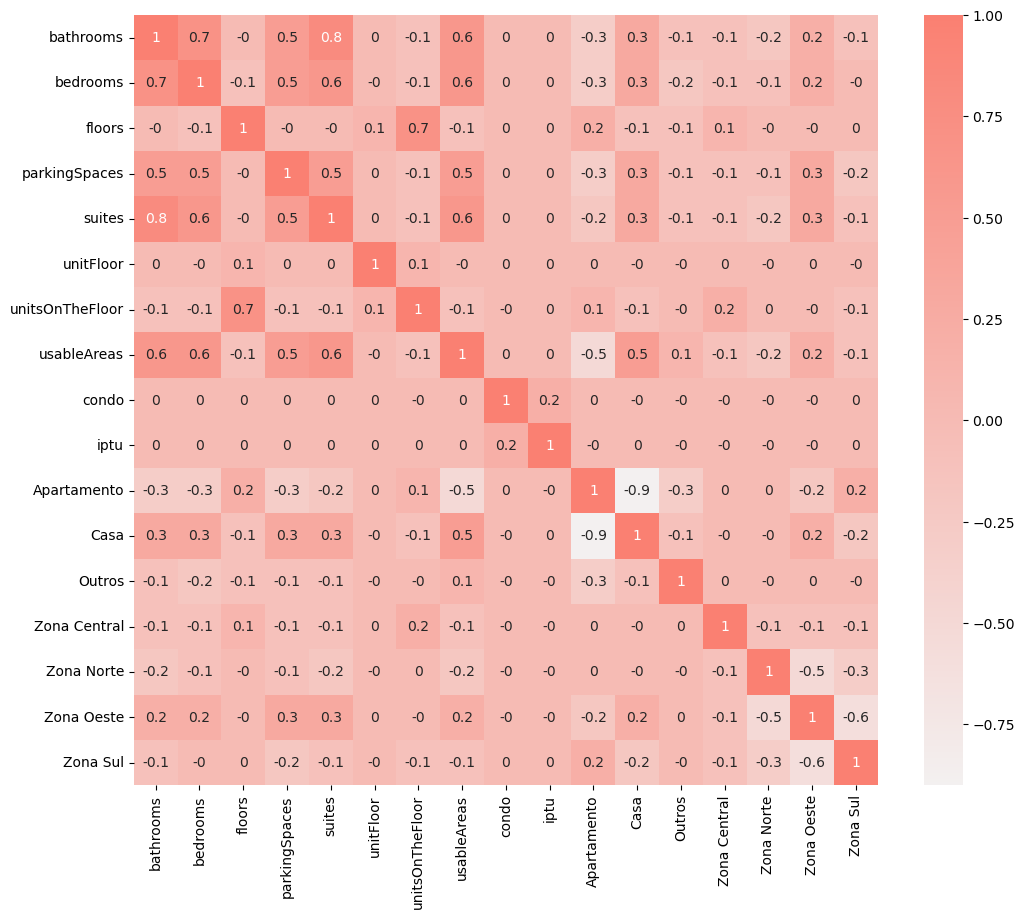

In [48]:
plt.figure(figsize=(12, 10))
paleta = sns.color_palette('light:salmon', as_cmap=True)
sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap=paleta)

# previsão

In [50]:
treino, teste = dataset_prep.randomSplit([0.7, 0.3], seed = 348)

In [51]:
treino.count()

48629

In [52]:
teste.count()

20810

In [53]:
lr = LinearRegression()

In [54]:
modelo_lr = lr.fit(treino)

24/11/23 19:12:43 WARN Instrumentation: [d803b1b9] regParam is zero, which might cause numerical instability and overfitting.
24/11/23 19:12:45 WARN Instrumentation: [d803b1b9] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [55]:
previsoes_lr_treino = modelo_lr.transform(treino)

In [57]:
previsoes_lr_treino.show(10, False)

+--------------------------------------------------------------------------+--------+------------------+
|features                                                                  |label   |prediction        |
+--------------------------------------------------------------------------+--------+------------------+
|(17,[0,1,2,3,4,5,6,7,10,13],[1.0,3.0,20.0,1.0,1.0,19.0,19.0,31.0,1.0,1.0])|260000.0|460837.15619804134|
|(17,[0,1,2,3,4,5,6,7,10,13],[2.0,3.0,20.0,1.0,2.0,14.0,8.0,70.0,1.0,1.0]) |500000.0|1150566.3763554913|
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,1.0,5.0,1.0,1.0,3.0,6.0,34.0,1.0,1.0])   |308615.0|105171.04244291381|
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,1.0,14.0,1.0,1.0,14.0,10.0,43.0,1.0,1.0])|279000.0|114847.09746510017|
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,2.0,8.0,2.0,1.0,7.0,8.0,103.0,1.0,1.0])  |350000.0|615537.6072385183 |
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,2.0,14.0,1.0,1.0,3.0,8.0,66.0,1.0,1.0])  |545000.0|353519.98139366385|
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,3.0,10.0,1.0,1.0,3.0,

# metricas

In [58]:
resumo_treino = modelo_lr.summary

In [59]:
resumo_treino.r2

0.6641481421947324

In [60]:
resumo_treino.rootMeanSquaredError

807879.1435829273

In [61]:
resumo_teste = modelo_lr.evaluate(teste)

In [62]:
resumo_teste.r2

0.6610668289169686

In [63]:
resumo_teste.rootMeanSquaredError

807451.9598870715

## tabela resumo regressão linear

In [64]:
print('Linear Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % resumo_treino.r2)
print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)

Linear Regression
Dados de Treino
R²: 0.664148
RMSE: 807879.143583

Dados de Teste
R²: 0.661067
RMSE: 807451.959887


# arvore de decisao - regressao

## previsao

In [66]:
dtr = DecisionTreeRegressor(seed=348, maxDepth=7)

In [67]:
modelo_dtr = dtr.fit(treino)

In [68]:
previsoes_dtr_treino = modelo_dtr.transform(treino)

In [70]:
previsoes_dtr_treino.show(10, False)

+--------------------------------------------------------------------------+--------+------------------+
|features                                                                  |label   |prediction        |
+--------------------------------------------------------------------------+--------+------------------+
|(17,[0,1,2,3,4,5,6,7,10,13],[1.0,3.0,20.0,1.0,1.0,19.0,19.0,31.0,1.0,1.0])|260000.0|345551.0194658216 |
|(17,[0,1,2,3,4,5,6,7,10,13],[2.0,3.0,20.0,1.0,2.0,14.0,8.0,70.0,1.0,1.0]) |500000.0|474957.92091603053|
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,1.0,5.0,1.0,1.0,3.0,6.0,34.0,1.0,1.0])   |308615.0|345551.0194658216 |
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,1.0,14.0,1.0,1.0,14.0,10.0,43.0,1.0,1.0])|279000.0|345551.0194658216 |
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,2.0,8.0,2.0,1.0,7.0,8.0,103.0,1.0,1.0])  |350000.0|834815.7186287193 |
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,2.0,14.0,1.0,1.0,3.0,8.0,66.0,1.0,1.0])  |545000.0|474957.92091603053|
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,3.0,10.0,1.0,1.0,3.0,

## metricas

In [78]:
evaluator = RegressionEvaluator()

print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: 'r2'}))
print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: 'rmse'}))

0.7946827084373824


631662.772573882


In [79]:
previsoes_dtr_teste = modelo_dtr.transform(teste)

In [80]:
previsoes_dtr_teste.show(10, False)

+-------------------------------------------------------------------------+--------+-----------------+
|features                                                                 |label   |prediction       |
+-------------------------------------------------------------------------+--------+-----------------+
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,2.0,6.0,1.0,1.0,5.0,10.0,50.0,1.0,1.0]) |199000.0|345551.0194658216|
|(17,[0,1,2,3,4,5,6,7,10,14],[2.0,2.0,2.0,2.0,1.0,2.0,1.0,115.0,1.0,1.0]) |490000.0|834815.7186287193|
|(17,[0,1,2,3,4,5,6,7,10,14],[2.0,2.0,5.0,1.0,1.0,4.0,5.0,59.0,1.0,1.0])  |190000.0|345551.0194658216|
|(17,[0,1,2,3,4,5,6,7,10,14],[2.0,2.0,5.0,1.0,2.0,3.0,4.0,80.0,1.0,1.0])  |600000.0|585355.5001198753|
|(17,[0,1,2,3,4,5,6,7,10,14],[2.0,2.0,8.0,2.0,1.0,8.0,4.0,125.0,1.0,1.0]) |679000.0|834815.7186287193|
|(17,[0,1,2,3,4,5,6,7,10,14],[2.0,2.0,9.0,1.0,1.0,1.0,8.0,52.0,1.0,1.0])  |333000.0|345551.0194658216|
|(17,[0,1,2,3,4,5,6,7,10,14],[2.0,2.0,10.0,1.0,2.0,10.0,8.0,78.0,1.0,1.0]

In [81]:
print('Decision Tree Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))


Decision Tree Regression
Dados de Treino


R²: 0.794683


RMSE: 631662.772574

Dados de Teste


R²: 0.776549


RMSE: 655617.854002


# random forest - regressao

## previsao

In [83]:
rfr = RandomForestRegressor(seed=348, maxDepth=7, numTrees=3)

In [84]:
modelo_rfr = rfr.fit(treino)

In [85]:
previsoes_rfr_treino = modelo_rfr.transform(treino)

In [86]:
previsoes_rfr_treino.show(10, False)

+--------------------------------------------------------------------------+--------+-----------------+
|features                                                                  |label   |prediction       |
+--------------------------------------------------------------------------+--------+-----------------+
|(17,[0,1,2,3,4,5,6,7,10,13],[1.0,3.0,20.0,1.0,1.0,19.0,19.0,31.0,1.0,1.0])|260000.0|402204.1336853059|
|(17,[0,1,2,3,4,5,6,7,10,13],[2.0,3.0,20.0,1.0,2.0,14.0,8.0,70.0,1.0,1.0]) |500000.0|467325.300971562 |
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,1.0,5.0,1.0,1.0,3.0,6.0,34.0,1.0,1.0])   |308615.0|402204.1336853059|
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,1.0,14.0,1.0,1.0,14.0,10.0,43.0,1.0,1.0])|279000.0|402204.1336853059|
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,2.0,8.0,2.0,1.0,7.0,8.0,103.0,1.0,1.0])  |350000.0|646029.7941421948|
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,2.0,14.0,1.0,1.0,3.0,8.0,66.0,1.0,1.0])  |545000.0|402204.1336853059|
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,3.0,10.0,1.0,1.0,3.0,12.0,70.0

## metricas

In [87]:
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))

0.7852152987778689


646061.9902087164


In [88]:
previsoes_rfr_teste = modelo_rfr.transform(teste)

In [89]:
previsoes_rfr_teste.show(10, False)

+-------------------------------------------------------------------------+--------+-----------------+
|features                                                                 |label   |prediction       |
+-------------------------------------------------------------------------+--------+-----------------+
|(17,[0,1,2,3,4,5,6,7,10,14],[1.0,2.0,6.0,1.0,1.0,5.0,10.0,50.0,1.0,1.0]) |199000.0|402204.1336853059|
|(17,[0,1,2,3,4,5,6,7,10,14],[2.0,2.0,2.0,2.0,1.0,2.0,1.0,115.0,1.0,1.0]) |490000.0|646029.7941421948|
|(17,[0,1,2,3,4,5,6,7,10,14],[2.0,2.0,5.0,1.0,1.0,4.0,5.0,59.0,1.0,1.0])  |190000.0|402204.1336853059|
|(17,[0,1,2,3,4,5,6,7,10,14],[2.0,2.0,5.0,1.0,2.0,3.0,4.0,80.0,1.0,1.0])  |600000.0|467325.300971562 |
|(17,[0,1,2,3,4,5,6,7,10,14],[2.0,2.0,8.0,2.0,1.0,8.0,4.0,125.0,1.0,1.0]) |679000.0|646029.7941421948|
|(17,[0,1,2,3,4,5,6,7,10,14],[2.0,2.0,9.0,1.0,1.0,1.0,8.0,52.0,1.0,1.0])  |333000.0|402204.1336853059|
|(17,[0,1,2,3,4,5,6,7,10,14],[2.0,2.0,10.0,1.0,2.0,10.0,8.0,78.0,1.0,1.0]

In [90]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Dados de Treino


R²: 0.785215


RMSE: 646061.990209

Dados de Teste


R²: 0.772139


RMSE: 662055.177308


# otimizaçao

## arvore de decisao

In [92]:
dtr = DecisionTreeRegressor()

In [ ]:
grid = ParamGridBuilder().addGrid(dtr.maxDepth, [2, 5, 10])\
                         .addGrid(dtr.maxBins, [10, 32, 45])\
                         .build()

In [95]:
evaluator = RegressionEvaluator()

In [96]:
dtr_cv = CrossValidator(estimator=dtr, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3, seed=348)

In [97]:
modelo_dtr_cv = dtr_cv.fit(treino)

In [98]:
previsoes_dtr_cv_teste = modelo_dtr_cv.transform(teste)

In [99]:
print('Decision Tree Regression')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Sem Cross Validation


R²: 0.776549


RMSE: 655617.854002

Com Cross Validation


R²: 0.804119


RMSE: 613840.886363


## random forest

In [100]:
rfr = RandomForestRegressor()

In [101]:
grid = ParamGridBuilder().addGrid(rfr.numTrees, [10, 20, 30]) \
                         .addGrid(rfr.maxDepth, [5, 10]) \
                         .addGrid(rfr.maxBins, [10, 32, 45]) \
                         .build()


In [102]:
evaluator = RegressionEvaluator()

In [103]:
rfr_cv = CrossValidator(estimator=rfr, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3)

In [104]:
modelo_rfr_cv = rfr_cv.fit(treino)

24/11/23 20:08:18 WARN DAGScheduler: Broadcasting large task binary with size 1493.2 KiB
24/11/23 20:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1452.8 KiB
24/11/23 20:08:26 WARN DAGScheduler: Broadcasting large task binary with size 1461.4 KiB
24/11/23 20:08:35 WARN DAGScheduler: Broadcasting large task binary with size 1635.3 KiB
24/11/23 20:08:36 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/11/23 20:08:41 WARN DAGScheduler: Broadcasting large task binary with size 1600.8 KiB
24/11/23 20:08:42 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/11/23 20:08:47 WARN DAGScheduler: Broadcasting large task binary with size 1612.2 KiB
24/11/23 20:08:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/11/23 20:08:58 WARN DAGScheduler: Broadcasting large task binary with size 1337.2 KiB
24/11/23 20:08:59 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/11/23 20:09:00 WARN DAGSchedul

In [105]:
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

In [106]:
print('Random Forest Regression')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Sem Cross Validation


R²: 0.772139


RMSE: 662055.177308

Com Cross Validation


R²: 0.832962


RMSE: 566849.159010


# prevendo resultados

In [107]:
dataset.show(15, False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone        |label  |condo|iptu |Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste  |45000.0|150.0|0.0  |0          |0   |1     |0           |0         |1        

In [108]:
X

['bathrooms',
 'bedrooms',
 'floors',
 'parkingSpaces',
 'suites',
 'unitFloor',
 'unitsOnTheFloor',
 'usableAreas',
 'condo',
 'iptu',
 'Apartamento',
 'Casa',
 'Outros',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul']

In [110]:
novo_imovel = [{
    'bathrooms': 3,
    'bedrooms': 2,
    'floors': 1,
    'parkingSpaces': 1,
    'suites': 2,
    'unitFloor':0,
    'unitsOnTheFloor':0,
    'usableAreas':200,
    'condo':200,
    'iptu':0,
    'Apartamento':1,
    'Casa':0,
    'Outros':0,
    'Zona Central':1,
    'Zona Norte':0,
    'Zona Oeste':0,
    'Zona Sul':0,
    'label': 0}]


In [111]:
meu_imovel = spark.createDataFrame(novo_imovel)

In [112]:
meu_imovel.show()

+-----------+----+------+------------+----------+----------+--------+---------+--------+-----+------+----+-----+-------------+------+---------+---------------+-----------+
|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|bathrooms|bedrooms|condo|floors|iptu|label|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|
+-----------+----+------+------------+----------+----------+--------+---------+--------+-----+------+----+-----+-------------+------+---------+---------------+-----------+
|          1|   0|     0|           1|         0|         0|       0|        3|       2|  200|     1|   0|    0|            1|     2|        0|              0|        200|
+-----------+----+------+------------+----------+----------+--------+---------+--------+-----+------+----+-----+-------------+------+---------+---------------+-----------+



In [113]:
assembler = VectorAssembler(inputCols=X, outputCol='features')

In [115]:
meu_imovel_vetorizado = assembler.transform(meu_imovel).select('features', 'label')

In [116]:
meu_imovel_vetorizado.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(17,[0,1,2,3,4,7,...|    0|
+--------------------+-----+



In [117]:
modelo_rfr_cv.transform(meu_imovel_vetorizado).show()

+--------------------+-----+-----------------+
|            features|label|       prediction|
+--------------------+-----+-----------------+
|(17,[0,1,2,3,4,7,...|    0|918327.5279373936|
+--------------------+-----+-----------------+

